In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
#params
weather_file = r"C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\raw\weather_train.csv"
train_file = r"C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\raw\train.csv"
building_file = r"C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\raw\building_metadata.csv"
output_file = r"C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\processed\merged_data.csv"

# Set seaborn style
sns.set(style="whitegrid")
colors = sns.color_palette("muted")

class_labels = {0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}


# Load

In [36]:
#RAM 
def randomize_and_filter_dataset(file_path, target_size, random_seed=42):
    df = pd.read_csv(file_path)
    print('Before:',df.shape)
    np.random.seed(random_seed)
    indices_to_keep = np.random.choice(df.index, size=target_size, replace=False)
    filtered_data = df.loc[indices_to_keep]
    return filtered_data
# Example usage:
train = randomize_and_filter_dataset(train_file, target_size=30)
print('After:',train.shape)

Before: (20216100, 4)
After: (30, 4)


In [37]:
#Read and merge train csv
#weather_train.csv: site_id
#train.csv : building_id
#building_metadata.csv: site_id building_id

def merge_csv_files(weather_file, train, building_file, output_file):
    # Read the CSV files
    weather_train = pd.read_csv(weather_file)
    #train = pd.read_csv(train_file)
    building_metadata = pd.read_csv(building_file)
    # Merge the dataframes
    merged_data =pd.merge(pd.merge(building_metadata, train, on='building_id'), weather_train, on='site_id')
    # Save the merged dataframe to a new CSV file
    merged_data.to_csv(output_file)
    return merged_data

train_df = merge_csv_files(weather_file, train, building_file, output_file)
print("Merged data saved to merged_data.csv", train_df.shape)

Merged data saved to merged_data.csv (262305, 17)


# EDA

In [46]:
def break_datetime(df):
  df['timestamp_x']= pd.to_datetime(df['timestamp_x'])
  df['hour']= np.uint8(df['timestamp_x'].dt.hour)
  df['dayofweek']= np.uint8(df['timestamp_x'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp_x'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp_x'].dt.dayofyear)
  df['day']= np.uint16(df['timestamp_x'].dt.day)
  df['year']= np.uint16(df['timestamp_x'].dt.year)
  return df

train_df= break_datetime(train_df)

In [49]:
train_df['meter_reading'].describe()

count    262305.000000
mean        181.936208
std         299.968978
min           0.000000
25%           9.250000
50%          29.180000
75%         247.000000
max        1106.100000
Name: meter_reading, dtype: float64

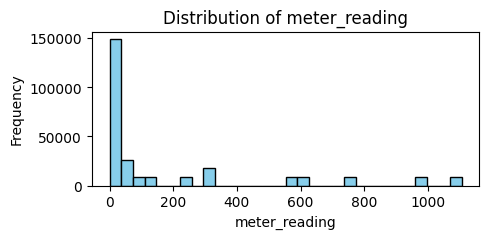

In [51]:
def plot_histogram(data, column_name, num_bins=30, color='skyblue', edgecolor='black', figsize=(5, 2)):
    """
    Generate a histogram for the specified column in the DataFrame.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column for which the histogram is to be generated.
        num_bins (int): Number of bins in the histogram.
        color (str): Color of the histogram bars.
        edgecolor (str): Color of the edges of the bars.
        figsize (tuple): Size of the figure (width, height).
    """
    plt.figure(figsize=figsize)
    plt.hist(data[column_name], bins=num_bins, color=color, edgecolor=edgecolor)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(train_df, 'meter_reading')

In [52]:
# Perform log transformation
train_df['log_' + 'meter_reading'] = np.log1p(train_df['meter_reading'])  

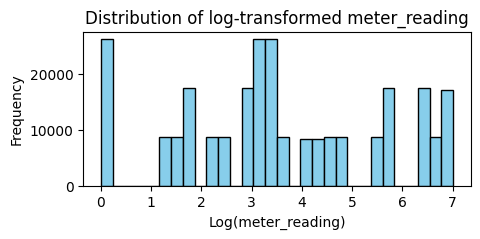

In [54]:
def plot_log_transformed_histogram(data, column_name, num_bins=30, color='skyblue', edgecolor='black', figsize=(5, 2)):
    """
    Generate a histogram for the log-transformed specified column in the DataFrame.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to be log-transformed and plotted.
        num_bins (int): Number of bins in the histogram.
        color (str): Color of the histogram bars.
        edgecolor (str): Color of the edges of the bars.
        figsize (tuple): Size of the figure (width, height).
    """
    log_transformed_column = 'log_' + column_name
    data[log_transformed_column] = np.log1p(data[column_name])  # Log-transform the specified column
    
    plt.figure(figsize=figsize)
    plt.hist(data[log_transformed_column], bins=num_bins, color=color, edgecolor=edgecolor)
    plt.title(f'Distribution of log-transformed {column_name}')
    plt.xlabel('Log(' + column_name + ')')
    plt.ylabel('Frequency')
    plt.show()

plot_log_transformed_histogram(train_df, 'meter_reading')

In [55]:
train_df['log_meter_reading'].describe()

count    262305.000000
mean          3.603006
std           2.026340
min           0.000000
25%           2.327278
50%           3.407179
75%           5.513429
max           7.009499
Name: log_meter_reading, dtype: float64

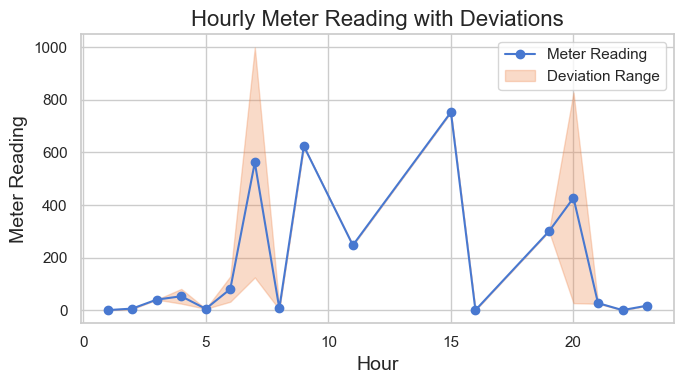

In [95]:

def plot_hourly_meter_reading_with_deviations(train_df):
    """
    Plot hourly meter readings with shaded region representing standard deviations.
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a datetime index and 'meter_reading' column.
        figsize (tuple): Size of the figure (width, height).
        colors (list): List of color values for the plot (default is None, which uses default colors).
    """
    
    # Calculate mean and standard deviation for each hour
    hourly_stats = train_df['meter_reading'].groupby(train_df.index.hour).agg(['mean', 'std'])
    # Extract hours, mean values, and standard deviations
    hours = hourly_stats.index
    mean_values = hourly_stats['mean']
    std_devs = hourly_stats['std']

    # Plotting the data with a shaded region representing standard deviations
    plt.figure(figsize=(7, 4))
    plt.plot(hours, mean_values, marker='o', color=colors[0], label='Meter Reading')
    plt.fill_between(hours, mean_values - std_devs, mean_values + std_devs, color=colors[1], alpha=0.3, label='Deviation Range')
    plt.title('Hourly Meter Reading with Deviations', fontsize=16)
    plt.xlabel('Hour', fontsize=14)
    plt.ylabel('Meter Reading', fontsize=14)
    plt.xticks(np.arange(0, 24, 5))  # Show ticks for each hour
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_hourly_meter_reading_with_deviations(train_df)

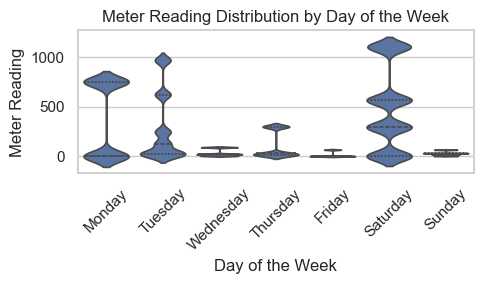

In [135]:
def plot_meter_reading_by_day(train_df):
    """
    Plot meter reading distribution by day of the week using a violin plot.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a datetime index and 'meter_reading' column.
    """
    # Extract day of the week from the datetime index
    train_df['day_of_week'] = train_df.dayofweek
    # Set the order of days for proper plotting
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Create a violin plot for each day of the week
    plt.figure(figsize=(5, 3))
    sns.violinplot(data=train_df, x="day_of_week", y="meter_reading",density_norm="width",inner="quartile")
    plt.title('Meter Reading Distribution by Day of the Week', fontsize=12)
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Meter Reading', fontsize=12)
    plt.xticks(ticks=range(len(day_order)), labels=day_order, rotation=45)
    plt.tight_layout()
    plt.show()
    
plot_meter_reading_by_day(train_df)


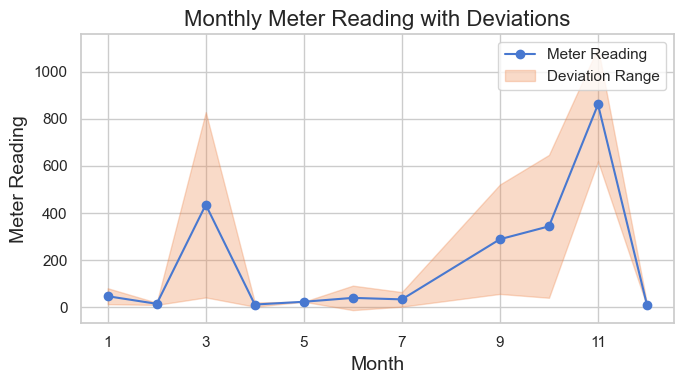

In [146]:
def plot_hourly_meter_reading_with_deviations(train_df):
    """
    Plot hourly meter readings with shaded region representing standard deviations.
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a datetime index and 'meter_reading' column.
        figsize (tuple): Size of the figure (width, height).
        colors (list): List of color values for the plot (default is None, which uses default colors).
    """
    
    # Calculate mean and standard deviation for each hour
    m_stats = train_df['meter_reading'].groupby(train_df.index.month).agg(['mean', 'std'])
    # Extract hours, mean values, and standard deviations
    months = m_stats.index
    mean_values = m_stats['mean']
    std_devs = m_stats['std']

    # Plotting the data with a shaded region representing standard deviations
    plt.figure(figsize=(7, 4))
    plt.plot(months, mean_values, marker='o', color=colors[0], label='Meter Reading')
    plt.fill_between(months, mean_values - std_devs, mean_values + std_devs, color=colors[1], alpha=0.3, label='Deviation Range')
    plt.title('Monthly Meter Reading with Deviations', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Meter Reading', fontsize=14)
    plt.xticks(np.arange(1, 13, 2))  # Show ticks for each hour
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_hourly_meter_reading_with_deviations(train_df)

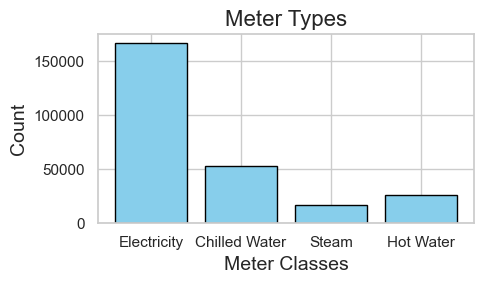

In [158]:

def plot_meter_classes(train_df, class_labels):
    """
    Plot a histogram of meter classes with specified class labels.
    
    Parameters:
        train_df (pd.DataFrame): The DataFrame containing the data with a 'meter' column.
        class_labels (dict): Dictionary mapping meter classes to corresponding names.
    """
    # Map the class labels to the 'meter' column and create a new column 'meter_class'
    train_df['meter_class'] = train_df['meter'].map(class_labels)

    # Create a histogram of meter classes
    plt.figure(figsize=(5, 3))
    plt.hist(train_df['meter'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5], align='mid', rwidth=0.8, color='skyblue', edgecolor='black')
    plt.title('Meter Types', fontsize=16)
    plt.xlabel('Meter Classes', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    # Set x-ticks in the middle of each class and label them
    plt.xticks(range(4), [class_labels[i] for i in range(4)])

    plt.tight_layout()
    plt.show()


plot_meter_classes(train_df, class_labels)

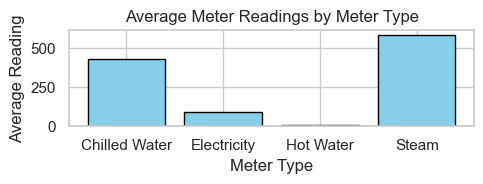

In [163]:

def average_meter_readings(train_df):
    # Calculate average meter readings by meter type
    average_meter_readings = train_df.groupby('meter_class')['meter_reading'].mean()

    # Create a histogram of average meter readings by meter type
    plt.figure(figsize=(5, 2))
    plt.bar(average_meter_readings.index, average_meter_readings.values, color='skyblue', edgecolor='black')
    plt.title('Average Meter Readings by Meter Type', fontsize=12)
    plt.xlabel('Meter Type', fontsize=12)
    plt.ylabel('Average Reading', fontsize=12)

    plt.tight_layout()
    plt.show()
    
average_meter_readings(train_df)

In [167]:
train_df.primary_use.unique()

array(['Office', 'Education', 'Entertainment/public assembly',
       'Public services', 'Technology/science', 'Parking',
       'Food sales and service'], dtype=object)

In [172]:
def plot_meter_classes(train_df):
    # Create a histogram of meter classes
    plt.figure(figsize=(9, 3))
    plt.hist(train_df['primary_use'], align='mid', rwidth=0.8, color='skyblue', edgecolor='black')
    plt.title('Meter Types', fontsize=16)
    plt.xlabel('Meter Classes', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    plt.tight_layout()
    plt.show()


plot_meter_classes(train_df)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001D783CE9620> (for post_execute):


KeyboardInterrupt: 